# Evaluation
This notebook will walk you step by step through the process of using the detection results files included in the zip folders of each pre-trained model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from itertools import cycle
from PIL import Image
import numpy as np
import pandas as pd
import pickle
import os
import copy

np.random.seed(1)

In [ ]:
EPSILON = 1e-5
# Load GTSDB validation images
CLASSES = ['prohibitory','mandatory','danger']
#Path to the German Traffic Sign Detection Benchmark dataset
DATASET_PATH = '/content/drive/MyDrive/Traffic_sign_detect_rec/'
#!unzip '/content/drive/MyDrive/Traffic_sign_detect_rec/gtsdb_data.zip'
!unzip '/content/drive/MyDrive/Traffic_sign_detect_rec/archive.zip' -d '/content/dataset'
!unzip '/content/drive/MyDrive/Traffic_sign_detect_rec/faster_rcnn_resnet50.zip' -d '/content/models/faster_rcnn_resnet50'
full_set = ['%05d.jpg' % x for x in range(900)]
valid_set = full_set[600:900]

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/dataset/train/5/00005_00053_00015.png  
  inflating: /content/dataset/train/5/00005_00053_00016.png  
  inflating: /content/dataset/train/5/00005_00053_00017.png  
  inflating: /content/dataset/train/5/00005_00053_00018.png  
  inflating: /content/dataset/train/5/00005_00053_00019.png  
  inflating: /content/dataset/train/5/00005_00053_00020.png  
  inflating: /content/dataset/train/5/00005_00053_00021.png  
  inflating: /content/dataset/train/5/00005_00053_00022.png  
  inflating: /content/dataset/train/5/00005_00053_00023.png  
  inflating: /content/dataset/train/5/00005_00053_00024.png  
  inflating: /content/dataset/train/5/00005_00053_00025.png  
  inflating: /content/dataset/train/5/00005_00053_00026.png  
  inflating: /content/dataset/train/5/00005_00053_00027.png  
  inflating: /content/dataset/train/5/00005_00053_00028.png  
  inflating: /content/dataset/train/5/00005_00053_00029.png  
  inflating: 

In [ ]:
category_index = {1: {'id': 1, 'name': 'prohibitory'},
 2: {'id': 2, 'name': 'mandatory'},
 3: {'id': 3, 'name': 'danger'}}
categories = [{'id': 1, 'name': 'prohibitory'},
 {'id': 2, 'name': 'mandatory'},
 {'id': 3, 'name': 'danger'}]

## Load detection results

In [ ]:
#MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous'
# MODEL_NAME = 'faster_rcnn_resnet_101'
MODEL_NAME = 'faster_rcnn_resnet50'
# MODEL_NAME = 'faster_rcnn_inception_v2'
# MODEL_NAME = 'rfcn_resnet101'
# MODEL_NAME = 'ssd_inception_v2'
# MODEL_NAME = 'ssd_mobilenet_v1'
# MODEL_NAME = 'yolo_v2'

In [ ]:
MODEL_PATH = os.path.join('/content/models', MODEL_NAME)
with open(os.path.join(MODEL_PATH, 'detections_output_result.pkl'), 'rb') as pickle_file:
    detections = pickle.load(pickle_file)
#print(detections[0])
for i in range(len(detections)) :
  detections[i]['file'] = detections[i]['file'].replace('.jpg','.png')
  detections[i]['file_path'] = '/content/dataset/Test/' + detections[i]['file']
  # print(detections[i])
print(detections[0])

{'gt_classes': [2, 1], 'file': '00624.png', 'gt_bboxes': [(387, 505, 434, 554), (821, 464, 845, 488)], 'pred_bboxes': [(385.96407651901245, 507.0496082305908, 430.3488564491272, 555.7212352752686), (821.3811922073364, 463.8789653778076, 846.0146522521973, 488.27195167541504)], 'file_path': '/content/dataset/Test/00624.png', 'confidences': [0.9999956, 0.9999908], 'pred_classes': [2, 1]}


## Helper code

In [ ]:
def filter_val_detections(detections):
    fdetects = []
    for d in detections:
        if d['file'] in valid_set:
            fdetects.append(d)
    return fdetects

In [ ]:
def filter_detections_by_width(detections, min_w, max_w):
    fdetects = []
    n_gt_bboxes = 0
    for d in detections:
        d_aux = copy.deepcopy(d)
        j = 0
        for i, bbox in enumerate(d['gt_bboxes']):
            w = bbox[2] - bbox[0]
            if w < min_w or w >= max_w:
                d_aux['gt_bboxes'].pop(i - j)
                d_aux['gt_classes'].pop(i - j)
                try:
                    d_aux['pred_bboxes'].pop(i - j)
                    d_aux['pred_classes'].pop(i - j)
                    d_aux['confidences'].pop(i - j)
                except IndexError:
                    print('Pred bbox num {} of image {} was not removed'.format(i,d_aux['file']))
                j += 1 
        n_gt_bboxes += len(d_aux['gt_bboxes'])
        fdetects.append(d_aux)
    print(n_gt_bboxes)
    return fdetects

In [ ]:
def get_detection_by_filename(detections, filename):
    for detection in detections:
        if detection['file'] == filename:
            return detection

In [ ]:
def plot_rectangle(bbox,ax,class_name,edgecolor,confidence=None):
    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]
    left = xmin
    right = xmax
    top = ymin
    bot = ymax
    ax.add_patch(
        plt.Rectangle((left, top),
                      right-left,
                      bot-top, fill=False,
                      edgecolor=edgecolor, linewidth=2)
        )
    label = '{:s}:'.format(class_name)
    label += ' {0:.2f}%'.format(confidence)
    label_pos_y = ((bot - top) / 2) + top + 3.5
    label_pos_x = right+10
    if class_name == 'danger':
        label_pos_x = left
        label_pos_y = top - 9
    elif class_name == 'prohibitory':
        label_pos_x = left - 30
        label_pos_y = bot + 15
    ax.text(label_pos_x, label_pos_y,label,
            bbox=dict(facecolor=edgecolor, edgecolor=edgecolor, alpha=1),
            fontsize=11)

In [ ]:
CLASSES_COLOR = ['DarkOrange','Aqua','Chartreuse']
def plot_dets(detection, model_name):
    fig, ax = plt.subplots(figsize=(20, 20))
    image = np.array(Image.open(detection['file_path']))
    image = np.squeeze(image)
    imWidth = image.shape[1]
    imHeight = image.shape[0]
    for j in range(len(detection['pred_bboxes'])):
        pred_class = detection['pred_classes'][j]
        bbox = detection['pred_bboxes'][j]
        confidence = detection['confidences'][j] * 100
        plot_rectangle(bbox,ax,category_index[pred_class]['name'],CLASSES_COLOR[pred_class-1], confidence)
    plt.axis('off')
    ax.imshow(image, aspect='equal')
    plt.savefig('image.png')
    #print(image)

In [ ]:
def intersection(bbgt, bb):
    # determine the (x, y)-coordinates of the intersection rectangle
    ixmin = max(bbgt[0], bb[0])
    iymin = max(bbgt[1], bb[1])
    ixmax = min(bbgt[2], bb[2])
    iymax = min(bbgt[3], bb[3])
    
    # compute the area of intersection rectangle
    iw = max(ixmax - ixmin, 0)
    ih = max(iymax - iymin, 0)
    intersArea = iw * ih
    
    return intersArea

In [ ]:
def union(bbgt, bb, intersArea):
    # compute the area of both the prediction and ground-truth rectangles
    boxgtArea = (bbgt[2] - bbgt[0]) * (bbgt[3] - bbgt[1])
    boxArea = (bb[2] - bb[0]) * (bb[3] - bb[1])
    unionArea = boxgtArea + boxArea - intersArea
    return unionArea

In [ ]:
# Returns the intersection over union of two rectangles, a and b, where each is an array [x,y,w,h]
def compute_iou(bbgt, bb):
    overlaps = np.zeros(len(bbgt))
    for i,gtBbox in enumerate(bbgt):
        inters = float(intersection(gtBbox, bb))
        uni = union(gtBbox, bb, inters)
        iou = inters/uni
        overlaps[i] = iou
    ioumax = np.max(overlaps)
    jmax = np.argmax(overlaps)
    return ioumax, jmax

In [ ]:
def naive_ap_calculation(rec,prec):
    """
    Take sum of P(k) * \Delta recall(k)
    """
    deltaRecall = []
    rec = np.insert(rec,0,0)
    for i in range(1,rec.shape[0]):
        deltaRecall.append( rec[i] - rec[i-1] ) # find differences
    deltaRecall = np.array(deltaRecall)
    ap = np.dot( deltaRecall,prec)
    return ap

In [ ]:
def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        # http://host.robots.ox.ac.uk/pascal/VOC/pubs/everingham10.pdf (page 313)
        
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation (from VOC 2010 challenge)
        # http://host.robots.ox.ac.uk/pascal/VOC/voc2012/devkit_doc.pdf (page 12)
        
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [ ]:
def match_gts_and_compute_prec_recall_ap(cls,detections,iouthresh=0.5):
    """
    INPUTS:
    -BB: predicted bounding boxes
    -BBGT: predicted bounding boxes, BBGT = R['bbox'].astype(float)
    OUTPUTS:
    -rec: recall
    -prec: precision
    -ap: average precision
    A bounding box reported by an algorithm is considered
    correct if its area intersection over union with a ground 
    truth bounding box is beyond 50%. If a lot of closely overlapping 
    bounding boxes hitting on a same ground truth, only one of
    them is counted as correct, and all the others are treated as false alarms
    """
    print('IoU threshold set to: {:.2f}'.format(iouthresh))
    GT_OBJECTS = {}
    BB = []
    BB_im_ids = []
    BB_confidences = []
    n_gt_bboxes = 0
    
    for dId,d in enumerate(detections):
        BBGT = []
        for i in range(len(d['gt_bboxes'])):
            if d['gt_classes'][i] == cls:
                BBGT.append(d['gt_bboxes'][i])
                n_gt_bboxes += 1
        GT_OBJECTS[d['file']] = {
            'bboxes' : np.asarray(BBGT),
            'detected?' : [False] * len(BBGT)
        }
        for i in range(len(d['pred_bboxes'])):
            if d['pred_classes'][i] == cls:
                BB.append(d['pred_bboxes'][i])
                BB_im_ids.append(d['file'])
                BB_confidences.append(d['confidences'][i])
      
    if n_gt_bboxes == 0:
        return None,None,None
    
    BB = np.asarray(BB)
    BB_confidences = np.asarray(BB_confidences)
    
    # sort by confidence
    if len(BB) > 0:
        sorted_ind = np.argsort(-BB_confidences)
        sorted_scores = np.sort(-BB_confidences)
        BB = BB[sorted_ind, :]
        BB_im_ids = [BB_im_ids[x] for x in sorted_ind]            
    
    num_detections = len(BB_im_ids)
    tp = np.zeros(num_detections)
    fp = np.zeros(num_detections)
    avg_overlap = []
    
    for d in range(num_detections):
        gt_info = GT_OBJECTS[BB_im_ids[d]]
        bb = BB[d, :].astype(float)
        BBGT = gt_info['bboxes'].astype(float)
        ioumax = -np.inf
        
        if BBGT.size > 0:
            # compute intersection over union
            ioumax, jmax = compute_iou(BBGT,bb)
        if ioumax > iouthresh:
            if not gt_info['detected?'][jmax]:
                tp[d] = 1. # true positive
                gt_info['detected?'][jmax] = 1
                avg_overlap.append(ioumax)
            else:
                fp[d] = 1. # false positive (multiple detection)
        else:
            fp[d] = 1. # false positive
        
    avg_overlap = np.array(avg_overlap) if len(avg_overlap) > 0 else np.array([0])
    
    # compute precision recall
    fp = np.cumsum(fp) if len(fp) > 0 else np.array([0])
    tp = np.cumsum(tp) if len(tp) > 0 else np.array([0])
    
    fn = n_gt_bboxes - tp[-1]
    
    rec = tp / np.maximum(tp + fn, np.finfo(np.float64).eps)
    # avoid divide by zero in case the first detection matches a difficult ground truth
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    
    ap = voc_ap(rec, prec)
    
    print("TP: {}".format(tp[-1]))
    print("FP: {}".format(fp[-1]))
    print("FN: {}".format(fn))
    class_name = category_index[cls]['name']
    print('Avg. overlap for {} = {:.4f}'.format(class_name, np.mean(avg_overlap)))
    
    print('Precision for {} = {:.4f}'.format(class_name, prec[-1]))
    print('Recall for {} = {:.4f}'.format(class_name, rec[-1]))
    
    return rec, prec, ap

In [ ]:
def plot_precision_recall(prec, recall, ap):
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [recall[-1]]))
    mpre = np.concatenate(([prec[0]], prec, [0.]))
    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(mrec, mpre, lw=2, color='navy',
             label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall: AP={0:0.2f}'.format(ap))
    plt.legend(loc="lower left")
    plt.show()

In [ ]:
def plot_full_precision_recall(data):
    fig, ax = plt.subplots(figsize=(6, 4))
    lines = ["-","--","-.",":"]
    linecycler = cycle(lines)
    for d in data:
        recall = d['recall']
        prec = d['precision']
        ap = d['ap']
        cls = d['class']
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], recall, [recall[-1]]))
        mpre = np.concatenate(([prec[0]], prec, [0.]))
        ax.plot(mrec, mpre, next(linecycler), label='{} (AP = {:.2f}%)'.format(cls,ap*100))
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="lower left")
    plt.draw()
    plt.tight_layout()
    plt.savefig('gtsdb_pre_rec_curves.pdf', format='pdf')
    plt.show()
    plt.clf()

In [ ]:
def compute_mean_average_precision(detections):
    """
    INPUTS:
    -detections: python list of objects with fields: class_given_obj, confidences, bboxes
    OUTPUTS:
    -mAP: float
    For each class, we compute average precision (AP)
    This score corresponds to the area under the precision-recall curve.
    The mean of these numbers is the mAP.
    """
    
    results = []
    plot_data = []

#     plotDets(detections)
    aps = []
    
    for category in categories:
        class_name = category['name']
        rec, prec, ap = match_gts_and_compute_prec_recall_ap(category['id'],detections,iouthresh=0.5)
        
        if rec is None:
            continue
        results.append({'class' : class_name, 'precision' : prec[-1], 'recall' : rec[-1], 'ap' : ap})
        plot_data.append({'class' : class_name, 'precision' : prec, 'recall' : rec, 'ap' : ap})
        if ap is not None:
            aps += [ap]
            print('AP for {} = {:.4f}'.format(class_name, ap))
        plot_precision_recall(prec, rec, ap)
    print('Mean AP = {:.4f}'.format(np.mean(aps)))
    print('~~~~~~~~')
    print('Results:')
    mAP = np.mean(aps)
    df = pd.DataFrame.from_records(results, columns=('class', 'precision', 'recall', 'ap'))
    print(df)
    plot_full_precision_recall(plot_data)
    return mAP

In [ ]:
def compute_mean_average_precision_COCO2016(detections):
    """
    INPUTS:
    -detections: python list of objects with fields: class_given_obj, confidences, bboxes
    OUTPUTS:
    -mAP: float
    For each class, we compute average precision (AP)
    This score corresponds to the area under the precision-recall curve.
    The mean of these numbers is the mAP.
    """

#     plotDets(detections)
    aps_class = []
    for category in categories:
        aps_iou = []
        for iouthresh in np.arange(.5, 1, .05):
            rec, prec, ap = match_gts_and_compute_prec_recall_ap(category['id'],detections,iouthresh)
            if ap is not None:
                aps_iou += [ap]
                print('AP for {} and IoU threshold {:.2f} = {:.4f}'.format(category['name'], iouthresh, ap))
            plot_precision_recall(prec, rec, ap)
        aps_class += [np.mean(aps_iou)] 
        print('Mean AP for {} = {:.4f}'.format(category['name'],np.mean(aps_iou)))
        
    print('Mean AP = {:.4f}'.format(np.mean(aps_class)))
    print('~~~~~~~~')
    print('Results:')
    for ap in aps_class:
        print('{:.3f}'.format(ap))
    print('{:.3f}'.format(np.mean(aps_class)))
    mAP = np.mean(aps_class)
    return mAP

## Filter detections

In [ ]:
# Filter detections that belong to validation images
detections = filter_val_detections(detections)

In [ ]:
# (0,32) (32,46) (46,1000)
detections_small = filter_detections_by_width(detections, 0, 32)
detections_medium = filter_detections_by_width(detections, 32, 46)
detections_large = filter_detections_by_width(detections, 46, 1000)

Pred bbox num 0 of image 00639.png was not removed
330
Pred bbox num 0 of image 00639.png was not removed
Pred bbox num 0 of image 00642.png was not removed
Pred bbox num 0 of image 00647.png was not removed
Pred bbox num 0 of image 00650.png was not removed
Pred bbox num 1 of image 00665.png was not removed
Pred bbox num 0 of image 00725.png was not removed
Pred bbox num 0 of image 00772.png was not removed
Pred bbox num 1 of image 00776.png was not removed
Pred bbox num 1 of image 00787.png was not removed
Pred bbox num 0 of image 00864.png was not removed
Pred bbox num 0 of image 00868.png was not removed
Pred bbox num 1 of image 00868.png was not removed
298
Pred bbox num 0 of image 00642.png was not removed
Pred bbox num 0 of image 00647.png was not removed
Pred bbox num 0 of image 00650.png was not removed
Pred bbox num 1 of image 00665.png was not removed
Pred bbox num 0 of image 00725.png was not removed
Pred bbox num 0 of image 00772.png was not removed
Pred bbox num 1 of imag

In [ ]:
print(detections[0])

{'gt_classes': [2, 1], 'file': '00624.png', 'gt_bboxes': [(387, 505, 434, 554), (821, 464, 845, 488)], 'pred_bboxes': [(385.96407651901245, 507.0496082305908, 430.3488564491272, 555.7212352752686), (821.3811922073364, 463.8789653778076, 846.0146522521973, 488.27195167541504)], 'file_path': '/content/dataset/Test/00624.png', 'confidences': [0.9999956, 0.9999908], 'pred_classes': [2, 1]}


## Eval VOC Pascal 2010+

IoU threshold set to: 0.50
TP: 555.0
FP: 15.0
FN: 2.0
Avg. overlap for prohibitory = 0.9328
Precision for prohibitory = 0.9737
Recall for prohibitory = 0.9964
AP for prohibitory = 0.9963


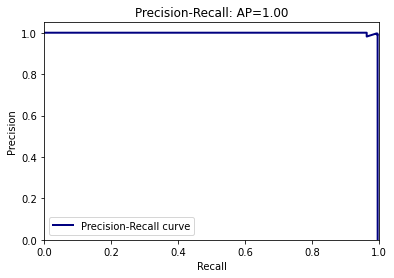

IoU threshold set to: 0.50
TP: 156.0
FP: 18.0
FN: 7.0
Avg. overlap for mandatory = 0.9308
Precision for mandatory = 0.8966
Recall for mandatory = 0.9571
AP for mandatory = 0.9569


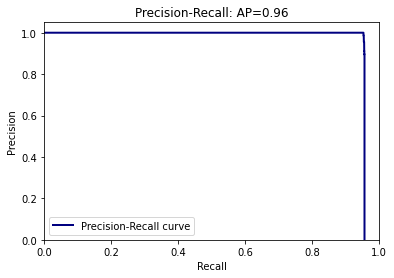

IoU threshold set to: 0.50
TP: 214.0
FP: 15.0
FN: 5.0
Avg. overlap for danger = 0.9441
Precision for danger = 0.9345
Recall for danger = 0.9772
AP for danger = 0.9749


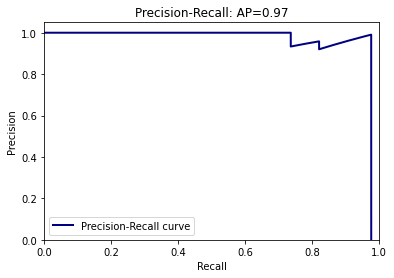

Mean AP = 0.9760
~~~~~~~~
Results:
         class  precision    recall        ap
0  prohibitory   0.973684  0.996409  0.996287
1    mandatory   0.896552  0.957055  0.956906
2       danger   0.934498  0.977169  0.974930


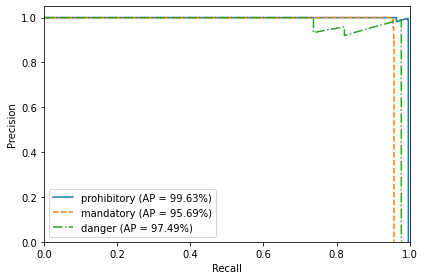

----- Small detections -----
IoU threshold set to: 0.50
TP: 199.0
FP: 19.0
FN: 15.0
Avg. overlap for prohibitory = 0.9245
Precision for prohibitory = 0.9128
Recall for prohibitory = 0.9299
AP for prohibitory = 0.8901


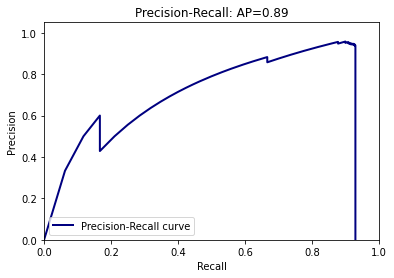

IoU threshold set to: 0.50
TP: 67.0
FP: 22.0
FN: 7.0
Avg. overlap for mandatory = 0.9174
Precision for mandatory = 0.7528
Recall for mandatory = 0.9054
AP for mandatory = 0.8602


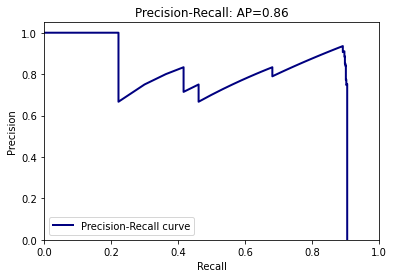

IoU threshold set to: 0.50
TP: 35.0
FP: 23.0
FN: 7.0
Avg. overlap for danger = 0.9514
Precision for danger = 0.6034
Recall for danger = 0.8333
AP for danger = 0.6435


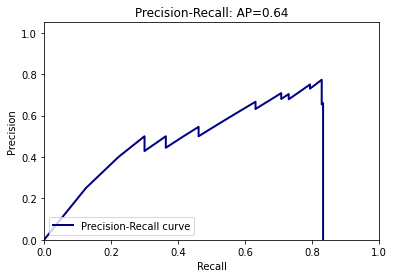

Mean AP = 0.7979
~~~~~~~~
Results:
         class  precision    recall        ap
0  prohibitory   0.912844  0.929907  0.890087
1    mandatory   0.752809  0.905405  0.860181
2       danger   0.603448  0.833333  0.643483


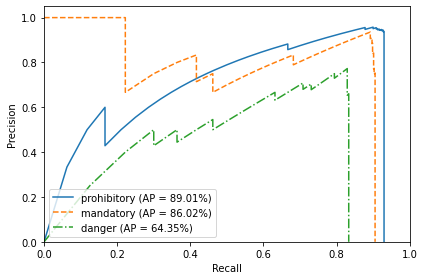

----- Medium detections -----
IoU threshold set to: 0.50
TP: 177.0
FP: 32.0
FN: 17.0
Avg. overlap for prohibitory = 0.9271
Precision for prohibitory = 0.8469
Recall for prohibitory = 0.9124
AP for prohibitory = 0.8535


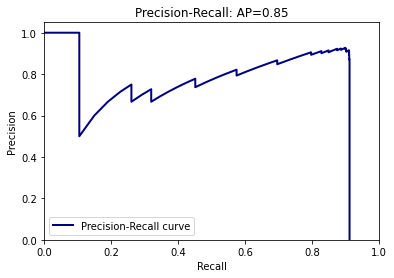

IoU threshold set to: 0.50
TP: 37.0
FP: 18.0
FN: 2.0
Avg. overlap for mandatory = 0.9231
Precision for mandatory = 0.6727
Recall for mandatory = 0.9487
AP for mandatory = 0.9468


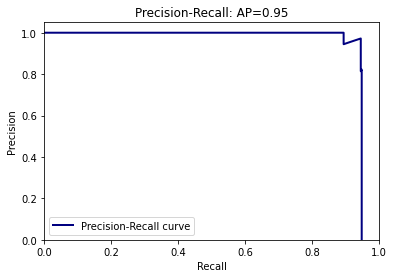

IoU threshold set to: 0.50
TP: 57.0
FP: 23.0
FN: 8.0
Avg. overlap for danger = 0.9434
Precision for danger = 0.7125
Recall for danger = 0.8769
AP for danger = 0.8258


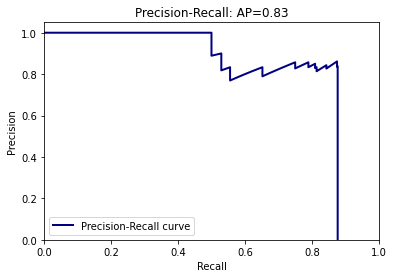

Mean AP = 0.8754
~~~~~~~~
Results:
         class  precision    recall        ap
0  prohibitory   0.846890  0.912371  0.853484
1    mandatory   0.672727  0.948718  0.946803
2       danger   0.712500  0.876923  0.825820


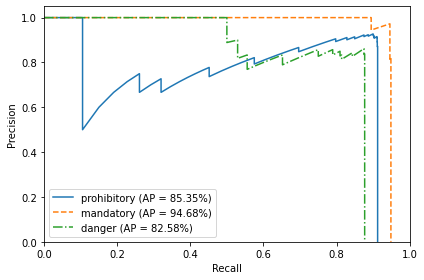

----- Large detections -----
IoU threshold set to: 0.50
TP: 141.0
FP: 32.0
FN: 8.0
Avg. overlap for prohibitory = 0.9570
Precision for prohibitory = 0.8150
Recall for prohibitory = 0.9463
AP for prohibitory = 0.9243


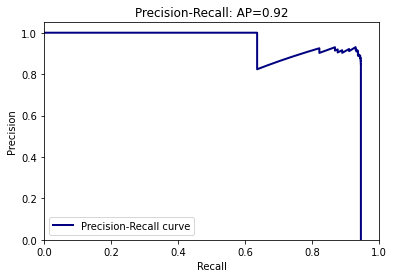

IoU threshold set to: 0.50
TP: 44.0
FP: 20.0
FN: 6.0
Avg. overlap for mandatory = 0.9511
Precision for mandatory = 0.6875
Recall for mandatory = 0.8800
AP for mandatory = 0.8648


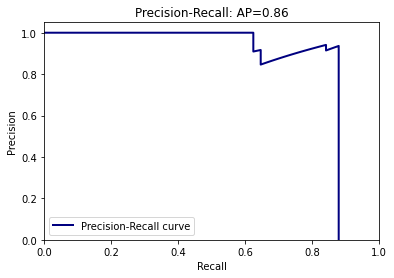

IoU threshold set to: 0.50
TP: 101.0
FP: 18.0
FN: 11.0
Avg. overlap for danger = 0.9447
Precision for danger = 0.8487
Recall for danger = 0.9018
AP for danger = 0.8687


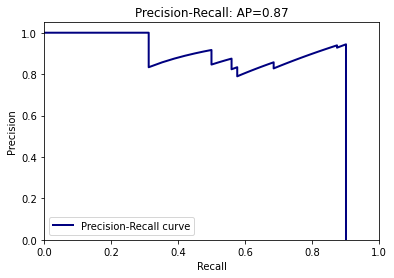

Mean AP = 0.8859
~~~~~~~~
Results:
         class  precision    recall        ap
0  prohibitory   0.815029  0.946309  0.924260
1    mandatory   0.687500  0.880000  0.864810
2       danger   0.848739  0.901786  0.868742


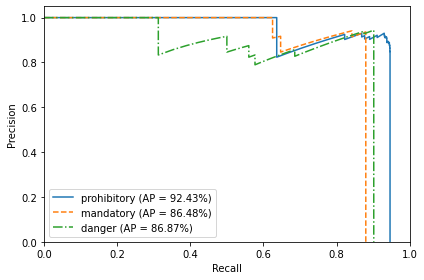

0.8859371733142593

<Figure size 432x288 with 0 Axes>

In [ ]:
compute_mean_average_precision(detections)
print("----- Small detections -----")
compute_mean_average_precision(detections_small)
print("----- Medium detections -----")
compute_mean_average_precision(detections_medium)
print("----- Large detections -----")
compute_mean_average_precision(detections_large)

## Eval Microsoft COCO 2016

IoU threshold set to: 0.50
TP: 555.0
FP: 15.0
FN: 2.0
Avg. overlap for prohibitory = 0.9328
Precision for prohibitory = 0.9737
Recall for prohibitory = 0.9964
AP for prohibitory and IoU threshold 0.50 = 0.9963


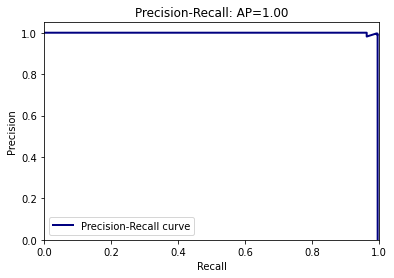

IoU threshold set to: 0.55
TP: 555.0
FP: 15.0
FN: 2.0
Avg. overlap for prohibitory = 0.9328
Precision for prohibitory = 0.9737
Recall for prohibitory = 0.9964
AP for prohibitory and IoU threshold 0.55 = 0.9963


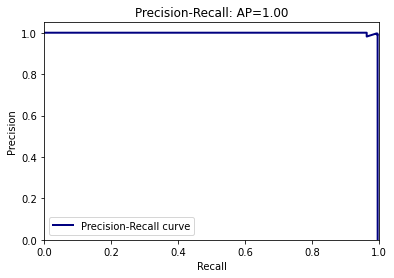

IoU threshold set to: 0.60
TP: 553.0
FP: 17.0
FN: 4.0
Avg. overlap for prohibitory = 0.9341
Precision for prohibitory = 0.9702
Recall for prohibitory = 0.9928
AP for prohibitory and IoU threshold 0.60 = 0.9925


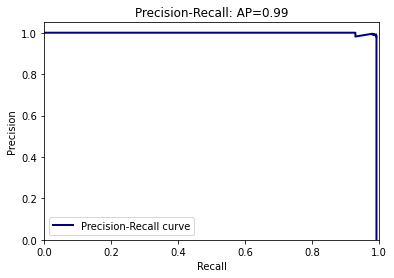

IoU threshold set to: 0.65
TP: 550.0
FP: 20.0
FN: 7.0
Avg. overlap for prohibitory = 0.9357
Precision for prohibitory = 0.9649
Recall for prohibitory = 0.9874
AP for prohibitory and IoU threshold 0.65 = 0.9868


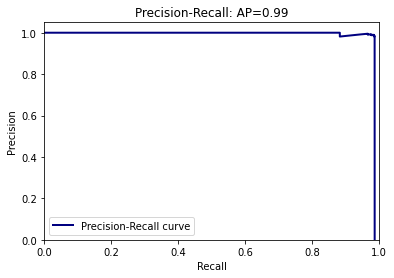

IoU threshold set to: 0.70
TP: 542.0
FP: 28.0
FN: 15.0
Avg. overlap for prohibitory = 0.9395
Precision for prohibitory = 0.9509
Recall for prohibitory = 0.9731
AP for prohibitory and IoU threshold 0.70 = 0.9696


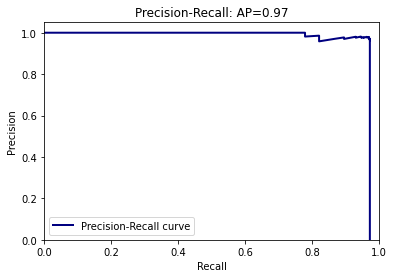

IoU threshold set to: 0.75
TP: 522.0
FP: 48.0
FN: 35.0
Avg. overlap for prohibitory = 0.9475
Precision for prohibitory = 0.9158
Recall for prohibitory = 0.9372
AP for prohibitory and IoU threshold 0.75 = 0.9244


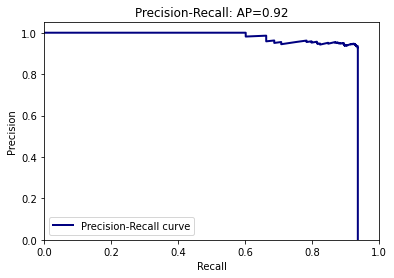

IoU threshold set to: 0.80
TP: 503.0
FP: 67.0
FN: 54.0
Avg. overlap for prohibitory = 0.9541
Precision for prohibitory = 0.8825
Recall for prohibitory = 0.9031
AP for prohibitory and IoU threshold 0.80 = 0.8769


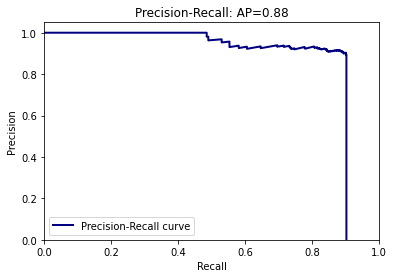

IoU threshold set to: 0.85
TP: 464.0
FP: 106.0
FN: 93.0
Avg. overlap for prohibitory = 0.9650
Precision for prohibitory = 0.8140
Recall for prohibitory = 0.8330
AP for prohibitory and IoU threshold 0.85 = 0.7579


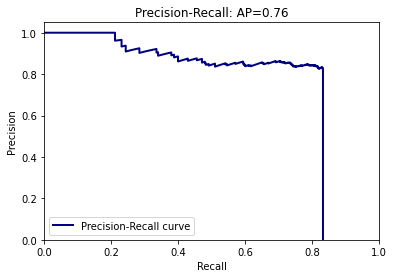

IoU threshold set to: 0.90
TP: 428.0
FP: 142.0
FN: 129.0
Avg. overlap for prohibitory = 0.9724
Precision for prohibitory = 0.7509
Recall for prohibitory = 0.7684
AP for prohibitory and IoU threshold 0.90 = 0.6393


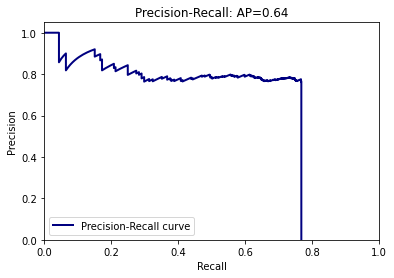

IoU threshold set to: 0.95
TP: 374.0
FP: 196.0
FN: 183.0
Avg. overlap for prohibitory = 0.9788
Precision for prohibitory = 0.6561
Recall for prohibitory = 0.6715
AP for prohibitory and IoU threshold 0.95 = 0.5133


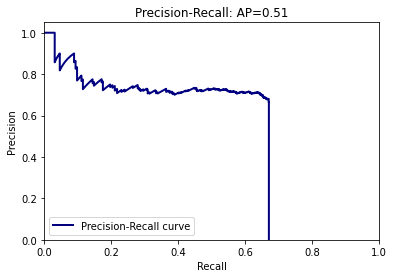

Mean AP for prohibitory = 0.8653
IoU threshold set to: 0.50
TP: 156.0
FP: 18.0
FN: 7.0
Avg. overlap for mandatory = 0.9308
Precision for mandatory = 0.8966
Recall for mandatory = 0.9571
AP for mandatory and IoU threshold 0.50 = 0.9569


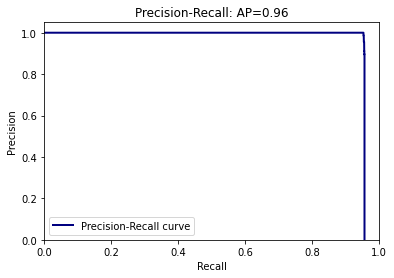

IoU threshold set to: 0.55
TP: 156.0
FP: 18.0
FN: 7.0
Avg. overlap for mandatory = 0.9308
Precision for mandatory = 0.8966
Recall for mandatory = 0.9571
AP for mandatory and IoU threshold 0.55 = 0.9569


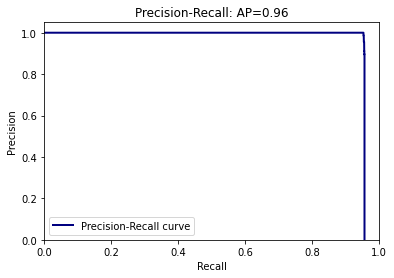

IoU threshold set to: 0.60
TP: 156.0
FP: 18.0
FN: 7.0
Avg. overlap for mandatory = 0.9308
Precision for mandatory = 0.8966
Recall for mandatory = 0.9571
AP for mandatory and IoU threshold 0.60 = 0.9569


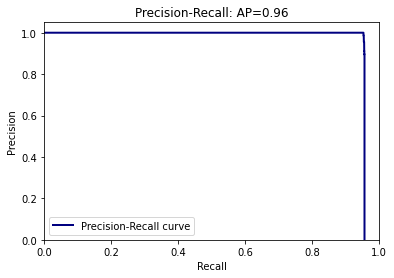

IoU threshold set to: 0.65
TP: 153.0
FP: 21.0
FN: 10.0
Avg. overlap for mandatory = 0.9369
Precision for mandatory = 0.8793
Recall for mandatory = 0.9387
AP for mandatory and IoU threshold 0.65 = 0.9385


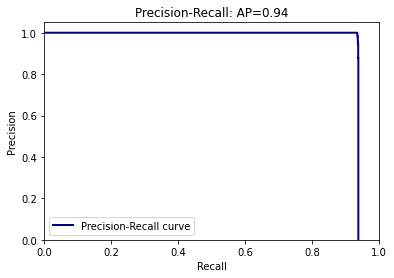

IoU threshold set to: 0.70
TP: 149.0
FP: 25.0
FN: 14.0
Avg. overlap for mandatory = 0.9438
Precision for mandatory = 0.8563
Recall for mandatory = 0.9141
AP for mandatory and IoU threshold 0.70 = 0.9127


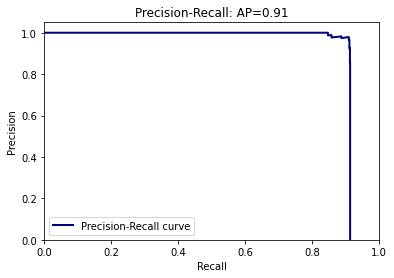

IoU threshold set to: 0.75
TP: 146.0
FP: 28.0
FN: 17.0
Avg. overlap for mandatory = 0.9484
Precision for mandatory = 0.8391
Recall for mandatory = 0.8957
AP for mandatory and IoU threshold 0.75 = 0.8755


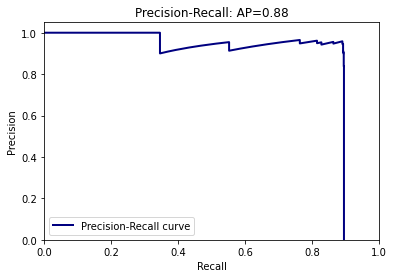

IoU threshold set to: 0.80
TP: 141.0
FP: 33.0
FN: 22.0
Avg. overlap for mandatory = 0.9544
Precision for mandatory = 0.8103
Recall for mandatory = 0.8650
AP for mandatory and IoU threshold 0.80 = 0.8199


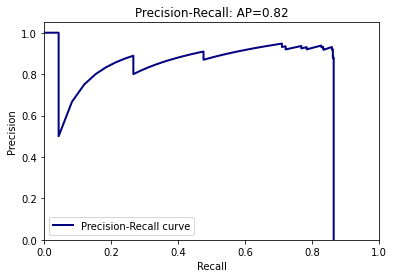

IoU threshold set to: 0.85
TP: 134.0
FP: 40.0
FN: 29.0
Avg. overlap for mandatory = 0.9610
Precision for mandatory = 0.7701
Recall for mandatory = 0.8221
AP for mandatory and IoU threshold 0.85 = 0.7496


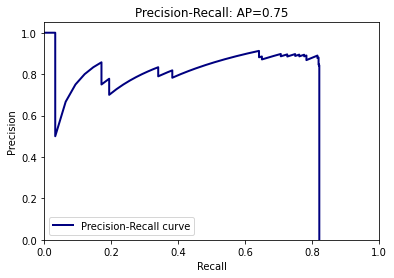

IoU threshold set to: 0.90
TP: 118.0
FP: 56.0
FN: 45.0
Avg. overlap for mandatory = 0.9732
Precision for mandatory = 0.6782
Recall for mandatory = 0.7239
AP for mandatory and IoU threshold 0.90 = 0.5888


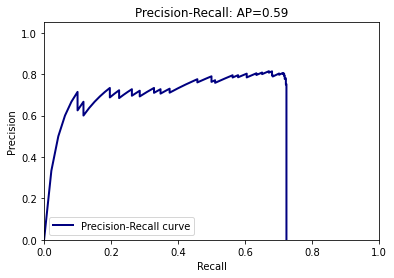

IoU threshold set to: 0.95
TP: 103.0
FP: 71.0
FN: 60.0
Avg. overlap for mandatory = 0.9788
Precision for mandatory = 0.5920
Recall for mandatory = 0.6319
AP for mandatory and IoU threshold 0.95 = 0.4694


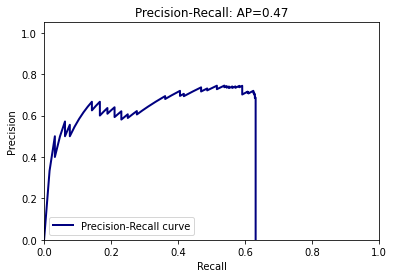

Mean AP for mandatory = 0.8225
IoU threshold set to: 0.50
TP: 214.0
FP: 15.0
FN: 5.0
Avg. overlap for danger = 0.9441
Precision for danger = 0.9345
Recall for danger = 0.9772
AP for danger and IoU threshold 0.50 = 0.9749


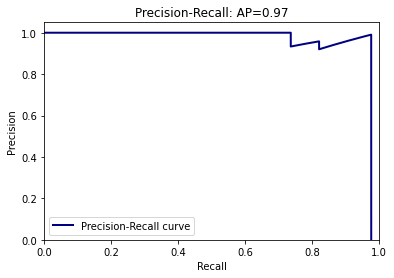

IoU threshold set to: 0.55
TP: 214.0
FP: 15.0
FN: 5.0
Avg. overlap for danger = 0.9441
Precision for danger = 0.9345
Recall for danger = 0.9772
AP for danger and IoU threshold 0.55 = 0.9749


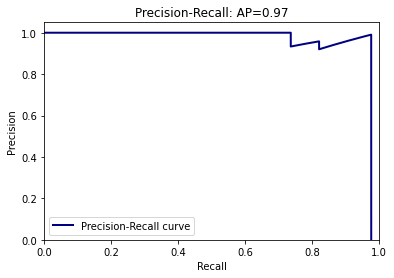

IoU threshold set to: 0.60
TP: 214.0
FP: 15.0
FN: 5.0
Avg. overlap for danger = 0.9441
Precision for danger = 0.9345
Recall for danger = 0.9772
AP for danger and IoU threshold 0.60 = 0.9749


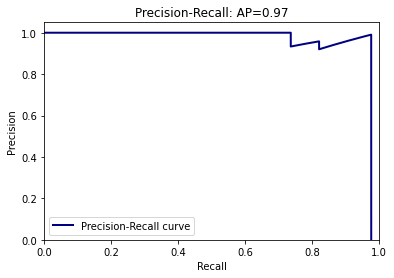

IoU threshold set to: 0.65
TP: 214.0
FP: 15.0
FN: 5.0
Avg. overlap for danger = 0.9441
Precision for danger = 0.9345
Recall for danger = 0.9772
AP for danger and IoU threshold 0.65 = 0.9749


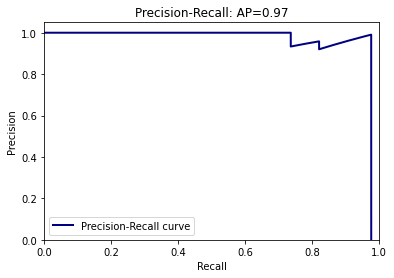

IoU threshold set to: 0.70
TP: 213.0
FP: 16.0
FN: 6.0
Avg. overlap for danger = 0.9454
Precision for danger = 0.9301
Recall for danger = 0.9726
AP for danger and IoU threshold 0.70 = 0.9700


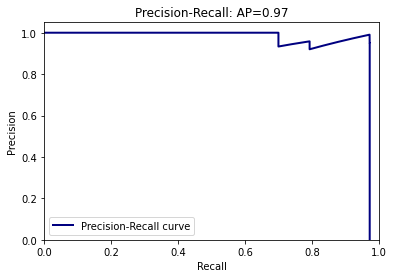

IoU threshold set to: 0.75
TP: 209.0
FP: 20.0
FN: 10.0
Avg. overlap for danger = 0.9496
Precision for danger = 0.9127
Recall for danger = 0.9543
AP for danger and IoU threshold 0.75 = 0.9334


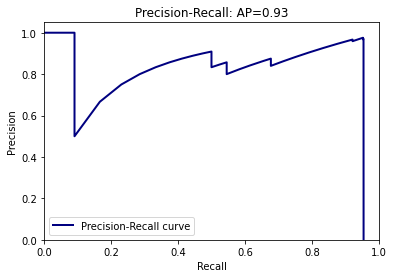

IoU threshold set to: 0.80
TP: 202.0
FP: 27.0
FN: 17.0
Avg. overlap for danger = 0.9555
Precision for danger = 0.8821
Recall for danger = 0.9224
AP for danger and IoU threshold 0.80 = 0.8820


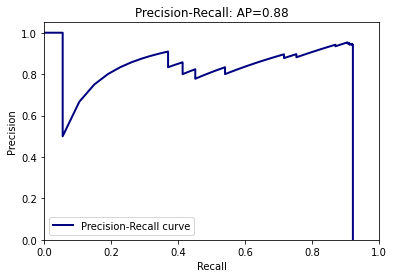

IoU threshold set to: 0.85
TP: 189.0
FP: 40.0
FN: 30.0
Avg. overlap for danger = 0.9644
Precision for danger = 0.8253
Recall for danger = 0.8630
AP for danger and IoU threshold 0.85 = 0.7786


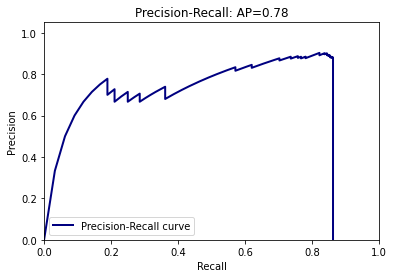

IoU threshold set to: 0.90
TP: 169.0
FP: 60.0
FN: 50.0
Avg. overlap for danger = 0.9752
Precision for danger = 0.7380
Recall for danger = 0.7717
AP for danger and IoU threshold 0.90 = 0.6189


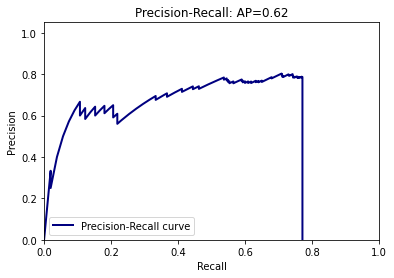

IoU threshold set to: 0.95
TP: 155.0
FP: 74.0
FN: 64.0
Avg. overlap for danger = 0.9795
Precision for danger = 0.6769
Recall for danger = 0.7078
AP for danger and IoU threshold 0.95 = 0.5295


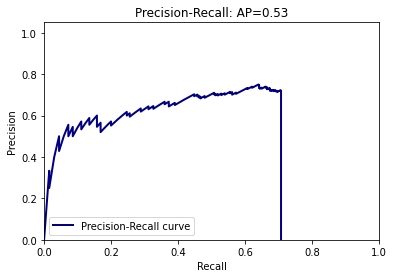

Mean AP for danger = 0.8612
Mean AP = 0.8497
~~~~~~~~
Results:
0.865
0.823
0.861
0.850


0.8496858915742633

In [ ]:
compute_mean_average_precision_COCO2016(detections)

## Plot detections

In [ ]:
sample = get_detection_by_filename(detections, '00000.png')
sample

{'confidences': [0.9999945],
 'file': '00000.png',
 'file_path': '/content/dataset/Test/00000.png',
 'gt_bboxes': [(774, 411, 815, 446)],
 'gt_classes': [3],
 'pred_bboxes': [(773.9934587478638,
   410.61267852783203,
   815.4576444625854,
   446.33827209472656)],
 'pred_classes': [3]}

In [ ]:
plot_dets(sample, MODEL_NAME)